<a href="https://colab.research.google.com/github/Yug-Oswal/Yug/blob/main/cats_v_dogsImgAug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

--2023-06-24 05:08:44--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 96.17.188.215, 2600:1413:b000:793::317f, 2600:1413:b000:78a::317f
Connecting to download.microsoft.com (download.microsoft.com)|96.17.188.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  76.2MB/s    in 10s     

2023-06-24 05:08:54 (75.4 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



In [2]:
import zipfile
import os

zippath = '/tmp/cats-and-dogs.zip'
zip_ref = zipfile.ZipFile(zippath, 'r')
zip_ref.extractall('/tmp')
zip_ref.close
os.listdir('/tmp')

['CDLA-Permissive-2.0.pdf',
 'pyright-356-gMKMNFgNtcQR',
 'dap_multiplexer.INFO',
 'initgoogle_syslog_dir.0',
 'PetImages',
 'dap_multiplexer.3d2e15c30207.root.log.INFO.20230624-050759.107',
 'readme[1].txt',
 'cats-and-dogs.zip',
 'python-languageserver-cancellation',
 'pyright-356-L6ItcweoTbNl',
 'language_service.3d2e15c30207.root.log.INFO.20230624-050844.347',
 'debugger_23cnndyw5n',
 'language_service.INFO']

In [3]:
# Checking subdirectories
source_path = '/tmp/PetImages'
os.listdir(source_path)

['Cat', 'Dog']

In [4]:
# Establishing path variables to subdirs
source_path_dog = os.path.join(source_path, "Dog")
source_path_cat = os.path.join(source_path, "Cat")

In [5]:
# Deletes all non-image files (there are two .db files bundled into the dataset)
!find /tmp/PetImages -type f ! -name "*.jpg" -exec rm {} +

In [6]:
# os.listdir returns a list containing all files under the given path
print(f"There are {len(os.listdir(source_path_dog))} images of dogs.")
print(f"There are {len(os.listdir(source_path_cat))} images of cats.")

There are 12500 images of dogs.
There are 12500 images of cats.


In [7]:
# Creating the training and validation directories
root_dir = '/tmp/cats-v-dogs'

import shutil

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
  train_path = os.path.join(root_path, "training")
  test_path = os.path.join(root_path, "validation")

  train_path_dogs, train_path_cats = os.path.join(train_path, "dogs"), os.path.join(train_path, "cats")
  test_path_dogs, test_path_cats = os.path.join(test_path, "dogs"), os.path.join(test_path, "cats")

  os.makedirs(train_path_dogs)
  os.mkdir(train_path_cats)
  os.makedirs(test_path_dogs)
  os.mkdir(test_path_cats)

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [8]:
# Traversing the directories

for rootdir, dirs, files in os.walk(root_dir):
  for subdir in dirs:
    print(os.path.join(rootdir, subdir))

/tmp/cats-v-dogs/validation
/tmp/cats-v-dogs/training
/tmp/cats-v-dogs/validation/cats
/tmp/cats-v-dogs/validation/dogs
/tmp/cats-v-dogs/training/cats
/tmp/cats-v-dogs/training/dogs


In [9]:
# Moving data as per given split size
import random

def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):

  dmgfile = 0
  for classes in os.listdir(SOURCE_DIR):
    filecount1, filecount2 = 0, 0
    files = os.listdir(os.path.join(SOURCE_DIR, classes))

    # Shuffling the list of files
    files = random.sample(files, len(files))

    if (classes == "Dog"):
      toclass = "dogs"
    else:
      toclass = "cats"

    # Empty the already existing directories if anything exists
    topath1 = os.path.join(TRAINING_DIR, toclass)
    topath2 = os.path.join(VALIDATION_DIR, toclass)
    shutil.rmtree(topath1)
    os.mkdir(topath1)
    shutil.rmtree(topath2)
    os.mkdir(topath2)

    # Counting and deleting corrupted files
    filtered_files = []
    for fname in files:
        file_path = os.path.join(SOURCE_DIR, classes, fname)
        if os.path.getsize(file_path):
            filtered_files.append(fname)
        else:
            dmgfile += 1
            print(f"{fname} is zero length, so ignoring")

    # Copying and moving files

    filebound = round(SPLIT_SIZE * len(filtered_files))

    for count in range(filebound):
      path = os.path.join(SOURCE_DIR, classes, filtered_files[count])
      topath = os.path.join(topath1, filtered_files[count])
      shutil.copyfile(path, topath)

    for count in range(filebound, len(filtered_files)):
      path = os.path.join(SOURCE_DIR, classes, filtered_files[count])
      topath = os.path.join(topath2, filtered_files[count])
      shutil.copyfile(path, topath)

    # Providing statistics
    print(f"There are {filebound} images of {toclass} for training.")
    print(f"There are {len(filtered_files) - filebound} images of {toclass} for testing")

  print(f"Found {dmgfile} corrupted file(s).")

In [10]:
# Testing split data function

training_dir = os.path.join(root_dir, "training")
validation_dir = os.path.join(root_dir, "validation")
split_data(source_path, training_dir, validation_dir, 0.9)

666.jpg is zero length, so ignoring
There are 11249 images of cats for training.
There are 1250 images of cats for testing
11702.jpg is zero length, so ignoring
There are 11249 images of dogs for training.
There are 1250 images of dogs for testing
Found 2 corrupted file(s).


In [11]:
# Neural Network part start

# Importing all required libraries and modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [18]:
# Creating a function which returns training and validation generators

def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                     rotation_range = 0.2,
                                     width_shift_range = 0.2,
                                     height_shift_range = 0.2,
                                     shear_range = 0.2,
                                     zoom_range = 0.2,
                                     horizontal_flip = True,
                                     fill_mode = 'nearest')

  train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    target_size = (150, 150),
                                                    batch_size = 128,
                                                    class_mode = 'binary')

  validation_generator = train_datagen.flow_from_directory(VALIDATION_DIR,
                                                         target_size = (150, 150),
                                                         batch_size = 25,
                                                         class_mode = 'binary')

  return train_generator, validation_generator

In [19]:
# Instantiating the generators
train_gen, val_gen = train_val_generators(training_dir, validation_dir)

Found 22498 images belonging to 2 classes.
Found 2500 images belonging to 2 classes.


In [14]:
# Defining model architecture and network
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape = (150, 150, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(32, (3, 3), input_shape = (150, 150, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), input_shape = (150, 150, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [15]:
# Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 64)       0

In [21]:
# Compiling the model
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), metrics = ['accuracy'])

In [22]:
# Training the model

history = model.fit(train_gen,
                    epochs = 15,
                    validation_data = val_gen,
                    validation_steps = 100,
                    verbose = 1)

Epoch 1/15
176/176 [==============================] - ETA: 0s - loss: 0.6499 - accuracy: 0.6089

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


176/176 [==============================] - 209s 1s/step - loss: 0.6499 - accuracy: 0.6089 - val_loss: 0.6208 - val_accuracy: 0.6716
Epoch 2/15
176/176 [==============================] - 201s 1s/step - loss: 0.5840 - accuracy: 0.6909 - val_loss: 0.5699 - val_accuracy: 0.6988
Epoch 3/15
176/176 [==============================] - 201s 1s/step - loss: 0.5538 - accuracy: 0.7146 - val_loss: 0.5255 - val_accuracy: 0.7424
Epoch 4/15
176/176 [==============================] - 202s 1s/step - loss: 0.5147 - accuracy: 0.7446 - val_loss: 0.4941 - val_accuracy: 0.7568
Epoch 5/15
176/176 [==============================] - 200s 1s/step - loss: 0.4926 - accuracy: 0.7618 - val_loss: 0.4991 - val_accuracy: 0.7576
Epoch 6/15
176/176 [==============================] - 199s 1s/step - loss: 0.4610 - accuracy: 0.7818 - val_loss: 0.4485 - val_accuracy: 0.7892
Epoch 7/15
176/176 [==============================] - 200s 1s/step - loss: 0.4532 - accuracy: 0.7877 - val_loss: 0.4525 - val_accuracy: 0.7884
Epoch 8/15

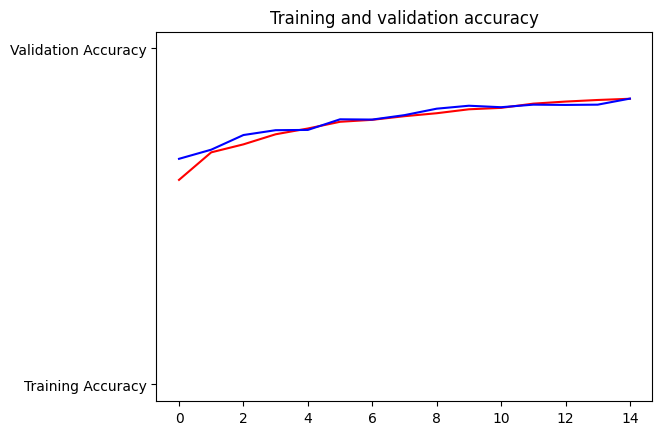

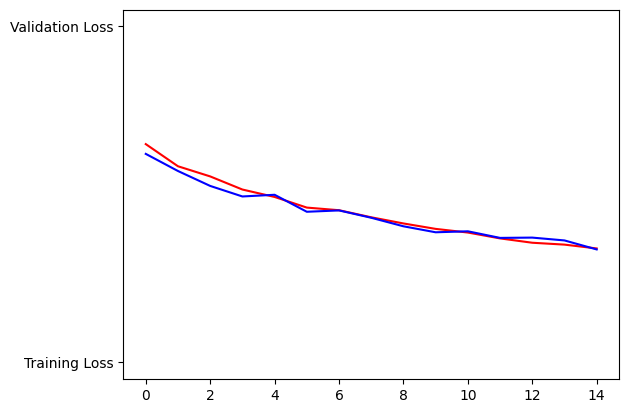

In [24]:
# Plotting the training of data (emphasis on the check for overfitting)

hist = history.history
epochs = range(len(hist['loss']))
acc = hist['accuracy']
val_acc = hist['val_accuracy']
loss = hist['loss']
val_loss = hist['val_loss']

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()